## Code for the experiments - training with Adam and Dropout
### Importing and preparing data
First we import the relevant packages. 

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical

Using TensorFlow backend.


Importing the dataset MNIST_fashion. It is an MNIST-like dataset, but contains images of clothing instead of numbers. The image size is the same as in MNIST. 

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Scaling the pixels to values between 0 and 1. 

In [4]:
train_images = train_images / 255.0
test_images = test_images / 255.0

The labels are given in integer values between 0 and 9. For the Self-Distillation we convert these into the one-hot representation, for example a trouser with label [1] now has label [0,1,0,0,0,0,0,0,0,0] with 1 at the first entry (note that counting starts with 0 here). 

In [5]:
train_labels_onehot = to_categorical(train_labels)
test_labels_onehot = to_categorical(test_labels)

Reshaping the data so that it fits into the functions later. 

In [6]:
im_rows=28
im_cols=28
im_shape=(im_rows,im_cols,1)

train_images = train_images.reshape(train_images.shape[0],*im_shape)
test_images = test_images.reshape(test_images.shape[0],*im_shape)

### Defining the models
Defining all the models that will be used later, so that we can see a summary. Note that the each model will be re-initialized later in each for-step, since each Self-Distillation step requires a fresh model that hasn't been trained yet. 

In [7]:
name = 'Convolutional_2_Layer'
cnn_model_2 = keras.Sequential([
    keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=im_shape),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(filters = 64, kernel_size = 3, activation ='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation ='softmax')], name = name)

name = 'Convolutional_4_Layer_CE'
cnn_model_4 = keras.Sequential([
    keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=im_shape),
    keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=im_shape),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(filters = 64, kernel_size = 3, activation ='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(filters = 128, kernel_size =3, activation ='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10)], name = name)

name = 'Feedforward_2_Layer'
ff_model_2 = keras.Sequential([
    keras.layers.Flatten(input_shape=im_shape),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(10, activation ='softmax')], name = name)


models = [cnn_model_2, cnn_model_4, ff_model_2]

In [8]:
for model in models:
    model.summary()

Model: "Convolutional_2_Layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 11, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7744)              0         
_________________________________________________________________
dense (Dense)                (None, 64)      

### Training the CNN's with cross-entropy loss
##### Training the 2-layer CNN with cross-entropy loss

In [9]:
train_labels_Iterations_2layerCE = np.zeros((60000,10,8),dtype='float32')
label_update_2layerCE = train_labels_onehot
predictions_2layerCE = np.zeros((10000,10,8),dtype='float32')
test_loss_2CNNCE = np.zeros(8,dtype='float32')
test_acc_2CNNCE = np.zeros(8,dtype='float32')
for i in range(8):
    print('ROUND',i+1)
    
    name = 'Convolutional_2_Layer_CE'
    cnn_model_2CE = keras.Sequential([
    keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=im_shape),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(filters = 64, kernel_size = 3, activation ='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10)], name = name)
    
    cnn_model_2CE.compile(optimizer='Adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    cnn_model_2CE.fit(train_images, label_update_2layerCE, epochs=10)
    probability_cnn_model_2CE = tf.keras.Sequential([cnn_model_2CE, 
                                         tf.keras.layers.Softmax()])
    test_loss_2CNNCE[i], test_acc_2CNNCE[i] = cnn_model_2CE.evaluate(test_images,  test_labels_onehot, verbose=2)
    print('\nTest accuracy:', test_acc_2CNNCE[i])
    label_update_2layerCE = probability_cnn_model_2CE.predict(train_images)
    predictions_2layerCE[:,:,i] = probability_cnn_model_2CE.predict(test_images)

ROUND 1
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 14s 237us/sample - loss: 0.4309 - accuracy: 0.8458
Epoch 2/10
60000/60000 [==============================] - 13s 214us/sample - loss: 0.2985 - accuracy: 0.8912
Epoch 3/10
60000/60000 [==============================] - 13s 213us/sample - loss: 0.2575 - accuracy: 0.9057
Epoch 4/10
60000/60000 [==============================] - 13s 210us/sample - loss: 0.2279 - accuracy: 0.9147
Epoch 5/10
60000/60000 [==============================] - 13s 211us/sample - loss: 0.2056 - accuracy: 0.9231
Epoch 6/10
60000/60000 [==============================] - 13s 210us/sample - loss: 0.1888 - accuracy: 0.9299
Epoch 7/10
60000/60000 [==============================] - 13s 212us/sample - loss: 0.1722 - accuracy: 0.9358
Epoch 8/10
60000/60000 [==============================] - 13s 211us/sample - loss: 0.1617 - accuracy: 0.9387
Epoch 9/10
60000/60000 [==============================] - 13s 211us/sample - loss: 0.1492 - accur

60000/60000 [==============================] - 13s 210us/sample - loss: 0.2249 - accuracy: 0.9692
10000/10000 - 1s - loss: 0.3041 - accuracy: 0.8967

Test accuracy: 0.8967
ROUND 8
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 13s 218us/sample - loss: 0.3788 - accuracy: 0.8959
Epoch 2/10
60000/60000 [==============================] - 13s 212us/sample - loss: 0.2767 - accuracy: 0.9404
Epoch 3/10
60000/60000 [==============================] - 13s 212us/sample - loss: 0.2575 - accuracy: 0.9513
Epoch 4/10
60000/60000 [==============================] - 13s 209us/sample - loss: 0.2482 - accuracy: 0.9582
Epoch 5/10
60000/60000 [==============================] - 13s 210us/sample - loss: 0.2422 - accuracy: 0.9623
Epoch 6/10
60000/60000 [==============================] - 13s 210us/sample - loss: 0.2392 - accuracy: 0.9643
Epoch 7/10
60000/60000 [==============================] - 13s 218us/sample - loss: 0.2366 - accuracy: 0.9653
Epoch 8/10
60000/60000 [==========

##### Training the 4layer convoluiontal NN with cross-entropy loss

In [10]:
train_labels_Iterations_4layerCE = np.zeros((60000,10,8),dtype='float32')
label_update_4layerCE = train_labels_onehot
predictions_4layerCE = np.zeros((10000,10,8),dtype='float32')
test_loss_4CNNCE = np.zeros(8,dtype='float32')
test_acc_4CNNCE = np.zeros(8,dtype='float32')
for i in range(8):
    print('ROUND',i+1)
    
    name = 'Convolutional_4_Layer_CE'
    cnn_model_4CE = keras.Sequential([
    keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=im_shape),
    keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=im_shape),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(filters = 64, kernel_size = 3, activation ='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(filters = 128, kernel_size =3, activation ='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10)], name = name)
    
    cnn_model_4CE.compile(optimizer='Adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    cnn_model_4CE.fit(train_images, label_update_4layerCE, epochs=10)
    probability_cnn_model_4CE = tf.keras.Sequential([cnn_model_4CE, 
                                         tf.keras.layers.Softmax()])
    test_loss_4CNNCE[i], test_acc_4CNNCE[i] = cnn_model_4CE.evaluate(test_images,  test_labels_onehot, verbose=2)
    print('\nTest accuracy:', test_acc_4CNNCE[i])
    label_update_4layerCE = probability_cnn_model_4CE.predict(train_images)
    predictions_4layerCE[:,:,i] = probability_cnn_model_4CE.predict(test_images)

ROUND 1
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 32s 534us/sample - loss: 0.6135 - accuracy: 0.7799
Epoch 2/10
60000/60000 [==============================] - 31s 514us/sample - loss: 0.4099 - accuracy: 0.8548
Epoch 3/10
60000/60000 [==============================] - 31s 516us/sample - loss: 0.3607 - accuracy: 0.8716
Epoch 4/10
60000/60000 [==============================] - 31s 524us/sample - loss: 0.3422 - accuracy: 0.8786
Epoch 5/10
60000/60000 [==============================] - 31s 519us/sample - loss: 0.3260 - accuracy: 0.8831
Epoch 6/10
60000/60000 [==============================] - 31s 513us/sample - loss: 0.3135 - accuracy: 0.8876
Epoch 7/10
60000/60000 [==============================] - 31s 518us/sample - loss: 0.3061 - accuracy: 0.8910
Epoch 8/10
60000/60000 [==============================] - 31s 517us/sample - loss: 0.3006 - accuracy: 0.8932
Epoch 9/10
60000/60000 [==============================] - 31s 523us/sample - loss: 0.2929 - accur

60000/60000 [==============================] - 31s 517us/sample - loss: 0.6165 - accuracy: 0.9401
Epoch 10/10
60000/60000 [==============================] - 31s 518us/sample - loss: 0.6178 - accuracy: 0.9398
10000/10000 - 2s - loss: 0.4569 - accuracy: 0.8478

Test accuracy: 0.8478
ROUND 8
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 32s 528us/sample - loss: 0.7795 - accuracy: 0.8449
Epoch 2/10
60000/60000 [==============================] - 31s 516us/sample - loss: 0.6701 - accuracy: 0.9170
Epoch 3/10
60000/60000 [==============================] - 31s 518us/sample - loss: 0.6571 - accuracy: 0.9287
Epoch 4/10
60000/60000 [==============================] - 31s 517us/sample - loss: 0.6514 - accuracy: 0.9314
Epoch 5/10
60000/60000 [==============================] - 31s 516us/sample - loss: 0.6497 - accuracy: 0.9342
Epoch 6/10
60000/60000 [==============================] - 31s 523us/sample - loss: 0.6467 - accuracy: 0.9354
Epoch 7/10
60000/60000 [=========

### Training the CNN's with mean-squared-error loss
##### Training the 2-layer CNN mean-squared-error loss

In [11]:
train_labels_Iterations_2layerMSE = np.zeros((60000,10,8),dtype='float32')
label_update_2layerMSE = train_labels_onehot
predictions_2layerMSE = np.zeros((10000,10,8),dtype='float32')
test_loss_2CNNMSE = np.zeros(8,dtype='float32')
test_acc_2CNNMSE = np.zeros(8,dtype='float32')
for i in range(8):
    print('ROUND',i+1)
    
    name = 'Convolutional_2_Layer_MSE'
    cnn_model_2MSE = keras.Sequential([
    keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=im_shape),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(filters = 64, kernel_size = 3, activation ='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10)], name = name)
    
    cnn_model_2MSE.compile(optimizer='Adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
    
    cnn_model_2MSE.fit(train_images, label_update_2layerMSE, epochs=10)
    probability_cnn_model_2MSE = tf.keras.Sequential([cnn_model_2MSE, 
                                         tf.keras.layers.Softmax()])
    test_loss_2CNNMSE[i], test_acc_2CNNMSE[i] = cnn_model_2MSE.evaluate(test_images,  test_labels_onehot, verbose=2)
    print('\nTest accuracy:', test_acc_2CNNMSE[i])
    label_update_2layerMSE = probability_cnn_model_2MSE.predict(train_images)
    predictions_2layerMSE[:,:,i] = probability_cnn_model_2MSE.predict(test_images)

ROUND 1
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 13s 209us/sample - loss: 0.0263 - accuracy: 0.8551
Epoch 2/10
60000/60000 [==============================] - 12s 201us/sample - loss: 0.0192 - accuracy: 0.8957
Epoch 3/10
60000/60000 [==============================] - 12s 203us/sample - loss: 0.0170 - accuracy: 0.9057
Epoch 4/10
60000/60000 [==============================] - 12s 202us/sample - loss: 0.0155 - accuracy: 0.9148
Epoch 5/10
60000/60000 [==============================] - 12s 202us/sample - loss: 0.0148 - accuracy: 0.9195
Epoch 6/10
60000/60000 [==============================] - 12s 205us/sample - loss: 0.0141 - accuracy: 0.9250
Epoch 7/10
60000/60000 [==============================] - 12s 203us/sample - loss: 0.0134 - accuracy: 0.9297
Epoch 8/10
60000/60000 [==============================] - 12s 203us/sample - loss: 0.0129 - accuracy: 0.9333
Epoch 9/10
60000/60000 [==============================] - 12s 205us/sample - loss: 0.0126 - accur

60000/60000 [==============================] - 12s 203us/sample - loss: 2.8016e-09 - accuracy: 0.2362
Epoch 8/10
60000/60000 [==============================] - 12s 202us/sample - loss: 2.0344e-09 - accuracy: 0.2232
Epoch 9/10
60000/60000 [==============================] - 12s 204us/sample - loss: 2.1701e-09 - accuracy: 0.2386
Epoch 10/10
60000/60000 [==============================] - 12s 203us/sample - loss: 2.1423e-09 - accuracy: 0.2597
10000/10000 - 1s - loss: 0.0900 - accuracy: 0.1000

Test accuracy: 0.1
ROUND 8
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 13s 210us/sample - loss: 1.7937e-04 - accuracy: 0.1226
Epoch 2/10
60000/60000 [==============================] - 12s 203us/sample - loss: 1.1023e-06 - accuracy: 0.1756
Epoch 3/10
60000/60000 [==============================] - 12s 202us/sample - loss: 4.3209e-08 - accuracy: 0.1600
Epoch 4/10
60000/60000 [==============================] - 12s 201us/sample - loss: 1.4689e-08 - accuracy: 0.1593
Epoc

##### Training the 4layer convoluiontal NN with mean-squared-error loss

In [12]:
train_labels_Iterations_4layerMSE = np.zeros((60000,10,8),dtype='float32')
label_update_4layerMSE = train_labels_onehot
predictions_4layerMSE = np.zeros((10000,10,8),dtype='float32')
test_loss_4CNNMSE = np.zeros(8,dtype='float32')
test_acc_4CNNMSE = np.zeros(8,dtype='float32')
for i in range(8):
    print('ROUND',i+1)
    
    name = 'Convolutional_4_Layer_MSE'
    cnn_model_4MSE = keras.Sequential([
    keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=im_shape),
    keras.layers.Conv2D(filters=32,kernel_size=3,input_shape=im_shape),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(filters = 64, kernel_size = 3, activation ='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(filters = 128, kernel_size =3, activation ='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10)], name = name)
    
    cnn_model_4MSE.compile(optimizer='Adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
    
    cnn_model_4MSE.fit(train_images, label_update_4layerMSE, epochs=10)
    probability_cnn_model_4MSE = tf.keras.Sequential([cnn_model_4MSE, 
                                         tf.keras.layers.Softmax()])
    test_loss_4CNNMSE[i], test_acc_4CNNMSE[i] = cnn_model_4MSE.evaluate(test_images,  test_labels_onehot, verbose=2)
    print('\nTest accuracy:', test_acc_4CNNMSE[i])
    label_update_4layerMSE = probability_cnn_model_4MSE.predict(train_images)
    predictions_4layerMSE[:,:,i] = probability_cnn_model_4MSE.predict(test_images)

ROUND 1
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 31s 521us/sample - loss: 0.0388 - accuracy: 0.7827
Epoch 2/10
60000/60000 [==============================] - 31s 514us/sample - loss: 0.0278 - accuracy: 0.8573
Epoch 3/10
60000/60000 [==============================] - 31s 514us/sample - loss: 0.0259 - accuracy: 0.8707
Epoch 4/10
60000/60000 [==============================] - 30s 508us/sample - loss: 0.0248 - accuracy: 0.8765
Epoch 5/10
60000/60000 [==============================] - 31s 517us/sample - loss: 0.0245 - accuracy: 0.8780
Epoch 6/10
60000/60000 [==============================] - 31s 517us/sample - loss: 0.0239 - accuracy: 0.8834
Epoch 7/10
60000/60000 [==============================] - 31s 515us/sample - loss: 0.0235 - accuracy: 0.8850-
Epoch 8/10
60000/60000 [==============================] - 31s 513us/sample - loss: 0.0230 - accuracy: 0.8891
Epoch 9/10
60000/60000 [==============================] - 31s 512us/sample - loss: 0.0230 - accu

60000/60000 [==============================] - 31s 514us/sample - loss: 7.4836e-10 - accuracy: 0.2133
Epoch 8/10
60000/60000 [==============================] - 31s 515us/sample - loss: 1.0289e-09 - accuracy: 0.3659
Epoch 9/10
60000/60000 [==============================] - 30s 507us/sample - loss: 1.4405e-09 - accuracy: 0.3605
Epoch 10/10
60000/60000 [==============================] - 31s 521us/sample - loss: 1.0090e-09 - accuracy: 0.3264
10000/10000 - 2s - loss: 0.0900 - accuracy: 0.1000

Test accuracy: 0.1
ROUND 8
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 32s 526us/sample - loss: 1.0496e-04 - accuracy: 0.4119
Epoch 2/10
60000/60000 [==============================] - 31s 514us/sample - loss: 1.6241e-10 - accuracy: 0.9839
Epoch 3/10
60000/60000 [==============================] - 31s 522us/sample - loss: 1.3195e-10 - accuracy: 0.9729
Epoch 4/10
60000/60000 [==============================] - 31s 519us/sample - loss: 6.6480e-12 - accuracy: 0.9922
Epoc

### Training the feed-forward NN with cross-entropy loss and mean-squared-error loss
###### Training the 2-layer feed-forward NN with cross-entropy loss

In [13]:
train_labels_Iterations_2layerFF_CE = np.zeros((60000,10,8),dtype='float32')
label_update_2layerFF_CE = train_labels_onehot
predictions_2layerFF_CE = np.zeros((10000,10,8),dtype='float32')
test_loss_2FFCE = np.zeros(8,dtype='float32')
test_acc_2FFCE = np.zeros(8,dtype='float32')
for i in range(8):
    print('ROUND',i+1)
    
    name = 'Feedforward_2_Layer_CE'
    ff_model_2CE = keras.Sequential([
    keras.layers.Flatten(input_shape=im_shape),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(10, activation ='softmax')], name = name)
    
    ff_model_2CE.compile(optimizer='Adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    ff_model_2CE.fit(train_images, label_update_2layerFF_CE, epochs=10)
    probability_ff_model_2CE = tf.keras.Sequential([ff_model_2CE, 
                                         tf.keras.layers.Softmax()])
    test_loss_2FFCE[i], test_acc_2FFCE[i] = ff_model_2CE.evaluate(test_images,  test_labels_onehot, verbose=2)
    print('\nTest accuracy:', test_acc_2FFCE[i])
    label_update_2layerFF_CE = probability_ff_model_2CE.predict(train_images)
    predictions_2layerFF_CE[:,:,i] = probability_ff_model_2CE.predict(test_images)

ROUND 1
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 76us/sample - loss: 1.6979 - accuracy: 0.7679
Epoch 2/10
60000/60000 [==============================] - 4s 70us/sample - loss: 1.6320 - accuracy: 0.8292
Epoch 3/10
60000/60000 [==============================] - 4s 72us/sample - loss: 1.6200 - accuracy: 0.8406
Epoch 4/10
60000/60000 [==============================] - 4s 73us/sample - loss: 1.6136 - accuracy: 0.8470
Epoch 5/10
60000/60000 [==============================] - 4s 70us/sample - loss: 1.6099 - accuracy: 0.8509
Epoch 6/10
60000/60000 [==============================] - 4s 70us/sample - loss: 1.6088 - accuracy: 0.8516
Epoch 7/10
60000/60000 [==============================] - 4s 73us/sample - loss: 1.6047 - accuracy: 0.8560
Epoch 8/10
60000/60000 [==============================] - 4s 70us/sample - loss: 1.6061 - accuracy: 0.8541
Epoch 9/10
60000/60000 [==============================] - 4s 70us/sample - loss: 1.6040 - accuracy: 0.8569
Epoch 


Test accuracy: 0.8293
ROUND 8
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 75us/sample - loss: 2.2444 - accuracy: 0.8999
Epoch 2/10
60000/60000 [==============================] - 4s 69us/sample - loss: 2.2404 - accuracy: 0.9462
Epoch 3/10
60000/60000 [==============================] - 4s 68us/sample - loss: 2.2397 - accuracy: 0.9554
Epoch 4/10
60000/60000 [==============================] - 4s 68us/sample - loss: 2.2395 - accuracy: 0.9585
Epoch 5/10
60000/60000 [==============================] - 5s 76us/sample - loss: 2.2392 - accuracy: 0.9635
Epoch 6/10
60000/60000 [==============================] - 4s 69us/sample - loss: 2.2392 - accuracy: 0.9647
Epoch 7/10
60000/60000 [==============================] - 4s 69us/sample - loss: 2.2390 - accuracy: 0.9677
Epoch 8/10
60000/60000 [==============================] - 4s 75us/sample - loss: 2.2389 - accuracy: 0.9693
Epoch 9/10
60000/60000 [==============================] - 4s 69us/sample - loss: 2.2389 - 

###### Training the 2-layer feed-forward NN with mean-squared-error loss

In [14]:
train_labels_Iterations_2layerFF_MSE = np.zeros((60000,10,8),dtype='float32')
label_update_2layerFF_MSE = train_labels_onehot
predictions_2layerFF_MSE = np.zeros((10000,10,8),dtype='float32')
test_loss_2FFMSE = np.zeros(8,dtype='float32')
test_acc_2FFMSE = np.zeros(8,dtype='float32')
for i in range(8):
    print('ROUND',i+1)
    
    name = 'Feedforward_2_Layer_MSE'
    ff_model_2MSE = keras.Sequential([
    keras.layers.Flatten(input_shape=im_shape),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(10, activation ='softmax')], name = name)
    
    ff_model_2MSE.compile(optimizer='Adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
    
    ff_model_2MSE.fit(train_images, label_update_2layerFF_MSE, epochs=10)
    probability_ff_model_2MSE = tf.keras.Sequential([ff_model_2MSE, 
                                         tf.keras.layers.Softmax()])
    test_loss_2FFMSE[i], test_acc_2FFMSE[i] = ff_model_2MSE.evaluate(test_images,  test_labels_onehot, verbose=2)
    print('\nTest accuracy:', test_acc_2FFMSE[i])
    label_update_2layerFF_MSE = probability_ff_model_2MSE.predict(train_images)
    predictions_2layerFF_MSE[:,:,i] = probability_ff_model_2MSE.predict(test_images)

ROUND 1
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 69us/sample - loss: 0.0264 - accuracy: 0.8158
Epoch 2/10
60000/60000 [==============================] - 4s 69us/sample - loss: 0.0203 - accuracy: 0.8603
Epoch 3/10
60000/60000 [==============================] - 4s 62us/sample - loss: 0.0189 - accuracy: 0.8686
Epoch 4/10
60000/60000 [==============================] - 4s 62us/sample - loss: 0.0179 - accuracy: 0.8761
Epoch 5/10
60000/60000 [==============================] - 4s 66us/sample - loss: 0.0171 - accuracy: 0.8825
Epoch 6/10
60000/60000 [==============================] - 4s 62us/sample - loss: 0.0167 - accuracy: 0.8857
Epoch 7/10
60000/60000 [==============================] - 4s 62us/sample - loss: 0.0161 - accuracy: 0.8911
Epoch 8/10
60000/60000 [==============================] - 4s 68us/sample - loss: 0.0157 - accuracy: 0.8919
Epoch 9/10
60000/60000 [==============================] - 4s 62us/sample - loss: 0.0153 - accuracy: 0.8960
Epoch 

60000/60000 [==============================] - 4s 68us/sample - loss: 3.6971e-11 - accuracy: 0.1437
Epoch 9/10
60000/60000 [==============================] - 4s 63us/sample - loss: 2.4766e-11 - accuracy: 0.1804
Epoch 10/10
60000/60000 [==============================] - 4s 63us/sample - loss: 2.0285e-11 - accuracy: 0.1661
10000/10000 - 1s - loss: 0.0900 - accuracy: 0.1002

Test accuracy: 0.1002
ROUND 8
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 67us/sample - loss: 3.3866e-06 - accuracy: 0.0735
Epoch 2/10
60000/60000 [==============================] - 4s 66us/sample - loss: 5.4624e-09 - accuracy: 0.0589
Epoch 3/10
60000/60000 [==============================] - 4s 62us/sample - loss: 1.2342e-09 - accuracy: 0.1107
Epoch 4/10
60000/60000 [==============================] - 4s 62us/sample - loss: 3.7565e-10 - accuracy: 0.1387
Epoch 5/10
60000/60000 [==============================] - 4s 68us/sample - loss: 1.3461e-10 - accuracy: 0.1427
Epoch 6/10
60000/

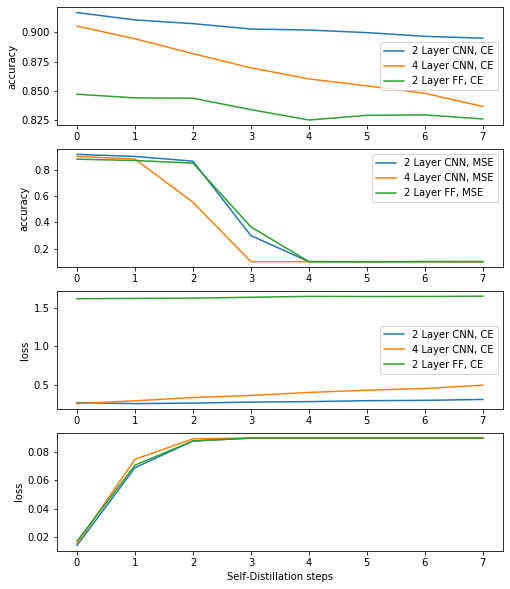

In [15]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(8, 10))

ax1.plot(test_acc_2CNNCE,label='2 Layer CNN, CE')
ax2.plot(test_acc_2CNNMSE,label='2 Layer CNN, MSE')
ax1.plot(test_acc_4CNNCE,label='4 Layer CNN, CE')
ax2.plot(test_acc_4CNNMSE,label='4 Layer CNN, MSE')
ax1.plot(test_acc_2FFCE,label='2 Layer FF, CE')
ax2.plot(test_acc_2FFMSE,label='2 Layer FF, MSE')

ax3.plot(test_loss_2CNNCE,label='2 Layer CNN, CE')
ax4.plot(test_loss_2CNNMSE,label='2 Layer CNN, MSE')
ax3.plot(test_loss_4CNNCE,label='4 Layer CNN, CE')
ax4.plot(test_loss_4CNNMSE,label='4 Layer CNN, MSE')
ax3.plot(test_loss_2FFCE,label='2 Layer FF, CE')
ax4.plot(test_loss_2FFMSE,label='2 Layer FF, MSE')

ax1.set_ylabel('accuracy')
ax2.set_ylabel('accuracy')
ax3.set_ylabel('loss')
ax4.set_ylabel('loss')
ax4.set_xlabel('Self-Distillation steps')
ax1.legend()
ax2.legend()
ax3.legend()
ax3.legend()
plt.savefig('Adam-Dropout-figure')
plt.show()